In [ ]:
# 구글 드라이브의 폴더와 구글 코랩 폴더 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 현재 경로 확인
!pwd

/content


In [ ]:
# drive/My Drive/Colab Notebooks 경로로 변경
%cd drive/My\ Drive/Colab\ Notebooks\

/content/drive/My Drive/Colab Notebooks


## Computer Vision Footprint

```
1998 - LeNet 5
2012 - AlexNet 
     - Gradient vanishin문제를 해결하는 ReLU를 사용 
     - LRN 사용 안했음
     - Overlapping Pooling(영향력이 크진 않음) 
     - Dropout(Overfitting 방지)  
2013 - ZFNet 
     - AlexNet을 Visualization통해 insight를 제공
     - HyperParameter tuning 방법론 제시  
     
     - Network in Network 
     - 1x1 Convolution 도입 (1. 차원 조절 2. non-linear 특성 부여 3. fully connected 처럼 사용)
     - Flatten 대신 사용하는 방법인 Global Average Pooling 도입  
     - 같은 형태를 반복하고 겹쳐서 사용하는 Stacking 도입  
2014 - GoogLeNet v1 (1등)
     - 1x1 convolution 활용
     - Inception module stacking 
     - Global average pooling 활용 

     - VGG (2등) 
2016 - GoogLeNet v4
```

## GoogLeNet

> ReLU와 같은 기법 덕에 Layer를 깊게 쌓을 수 있는 확신이 있었던 배경 때문에 Layer를 어떻게 깊게 쌓는지 여부가 중요한 포인트였다 <br> 

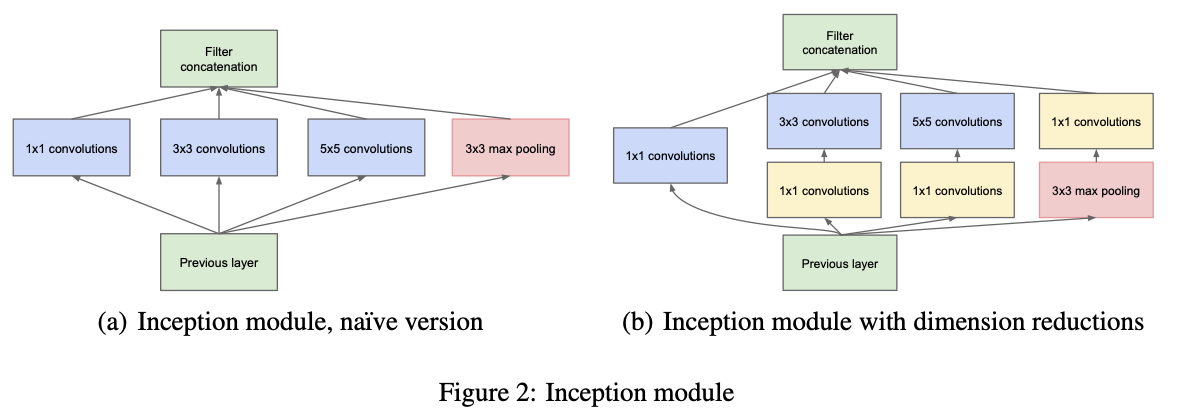

### GoogLeNet 특징

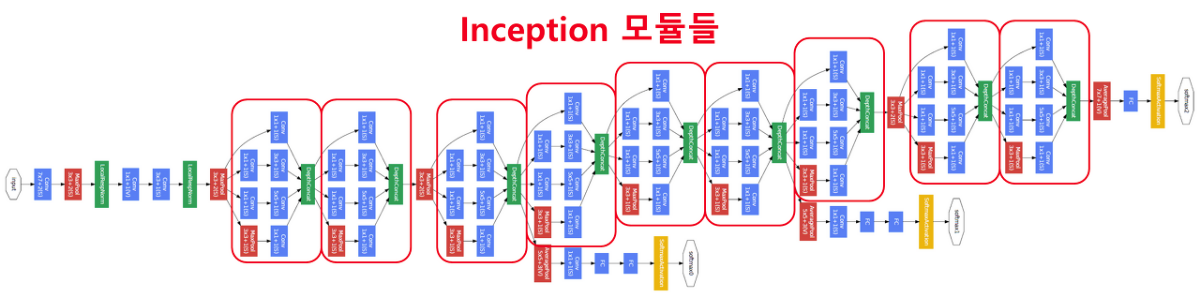

```python
1. 1x1 convolution 
- 차원 축소 효과 
- nonlinearity 특징 부여 
2. Inception module 
- 9개 inception module로 구성되어 있다 
- Inception moddule은 Hebbian rule에 의해 영향력이 가장 큰 부분이 연결성이 강화된다(weight가 커진다) 
- 실제 구현에서는 차원을 조절하여 inception module을 적용하였다 
3. Global average pooling 
4. Auxiliary classifier
- relu로 gradient vanishing 문제를 해결한듯 했으나 layer가 기존에 8 layer였던것에 비해 22 layer로 급격하게 늘었기 때문에 gradient vanishing 가능성이 생겼다 
- 따라서 네트워크 중간에 auxiliary classifier를 추가하여 중간 중간 결과를 낸다 

```

## Inception module




In [66]:
import tensorflow as tf 

In [67]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [68]:
# Inception module, naive version
input_ = tf.keras.Input((32,32,3))
conv1x1 = tf.keras.layers.Conv2D(3,1, padding='same', name='1x1')(input_) 
conv3x3 = tf.keras.layers.Conv2D(3,3, padding='same', name='3x3')(input_) 
conv5x5 = tf.keras.layers.Conv2D(3,3, padding='same', name='5x5')(input_) 
maxpool = tf.keras.layers.MaxPool2D(3,1, padding='same', name='pool')(input_) # unoverlapping 
concatenate = tf.keras.layers.Concatenate()([conv1x1,conv3x3,conv5x5,maxpool]) # 합치기 위해서 구조를 맞추어야 한다 

In [69]:
model = tf.keras.models.Model(input_, concatenate)

In [70]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
1x1 (Conv2D)                    (None, 32, 32, 3)    12          input_24[0][0]                   
__________________________________________________________________________________________________
3x3 (Conv2D)                    (None, 32, 32, 3)    84          input_24[0][0]                   
__________________________________________________________________________________________________
5x5 (Conv2D)                    (None, 32, 32, 3)    84          input_24[0][0]                   
___________________________________________________________________________________________

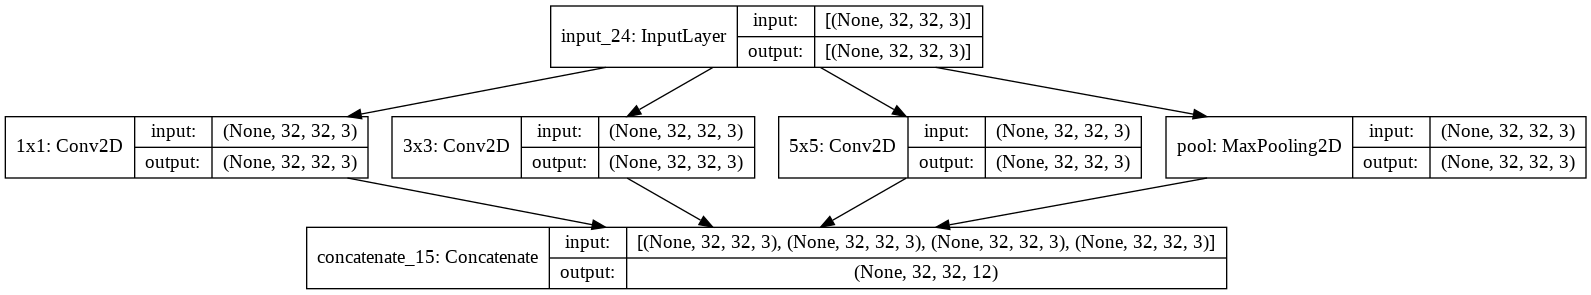

In [71]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [72]:
# Inception module with dimension reductions
input_ = tf.keras.Input((32,32,3))
conv1x1 = tf.keras.layers.Conv2D(3,1, padding='same', name='1x1')(input_) 
conv1x1_reduc3x3 = tf.keras.layers.Conv2D(2,1, padding='same', name='1x1_3x3')(input_) 
conv3x3 = tf.keras.layers.Conv2D(2,3, padding='same', name='3x3')(conv1x1_reduc3x3) 
conv1x1_reduc5x5 = tf.keras.layers.Conv2D(2,1, padding='same', name='1x1_5x5')(input_) 
conv5x5 = tf.keras.layers.Conv2D(2,3, padding='same', name='5x5')(conv1x1_reduc5x5) 
maxpool = tf.keras.layers.MaxPool2D(2,1, padding='same', name='pool')(input_) 
conv1x1_reduc_mp = tf.keras.layers.Conv2D(2,1, padding='same', name='1x1_pool')(maxpool) 
concatenate = tf.keras.layers.Concatenate(axis=-1)([conv1x1,conv3x3,conv5x5,conv1x1_reduc_mp]) # 합치기 위해서 구조를 맞추어야 한다 
# concatenate = tf.keras.layers.Concatenate([conv1x1,conv3x3,conv5x5,conv1x1_reduc_mp]) # 옵션을 주지 않을때 

In [73]:
model = tf.keras.models.Model(input_, concatenate)

In [74]:
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
1x1_3x3 (Conv2D)                (None, 32, 32, 2)    8           input_25[0][0]                   
__________________________________________________________________________________________________
1x1_5x5 (Conv2D)                (None, 32, 32, 2)    8           input_25[0][0]                   
__________________________________________________________________________________________________
pool (MaxPooling2D)             (None, 32, 32, 3)    0           input_25[0][0]                   
___________________________________________________________________________________________

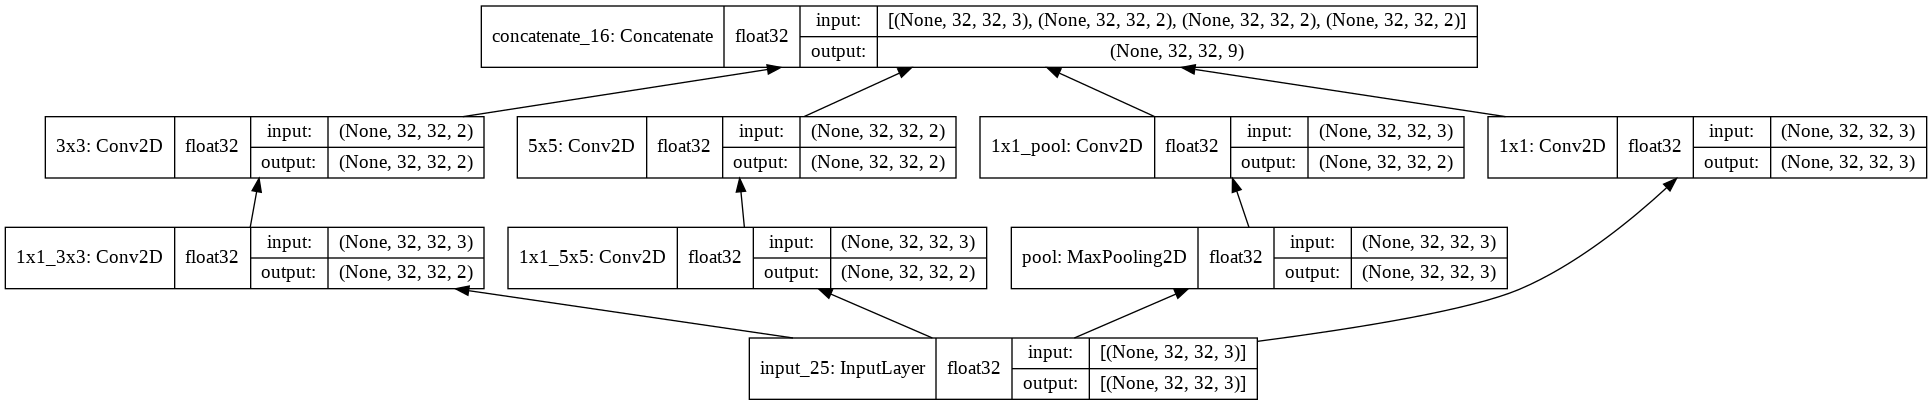

In [75]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="BT", show_dtype=True) # wide하게 분포되어 있기 때문에 parameter operator가 엄청 많다 / 이중에서 영향력 있는 것만 강한 연결성을 띄게 된다 

In [76]:
in3 = tf.keras.applications.InceptionV3()

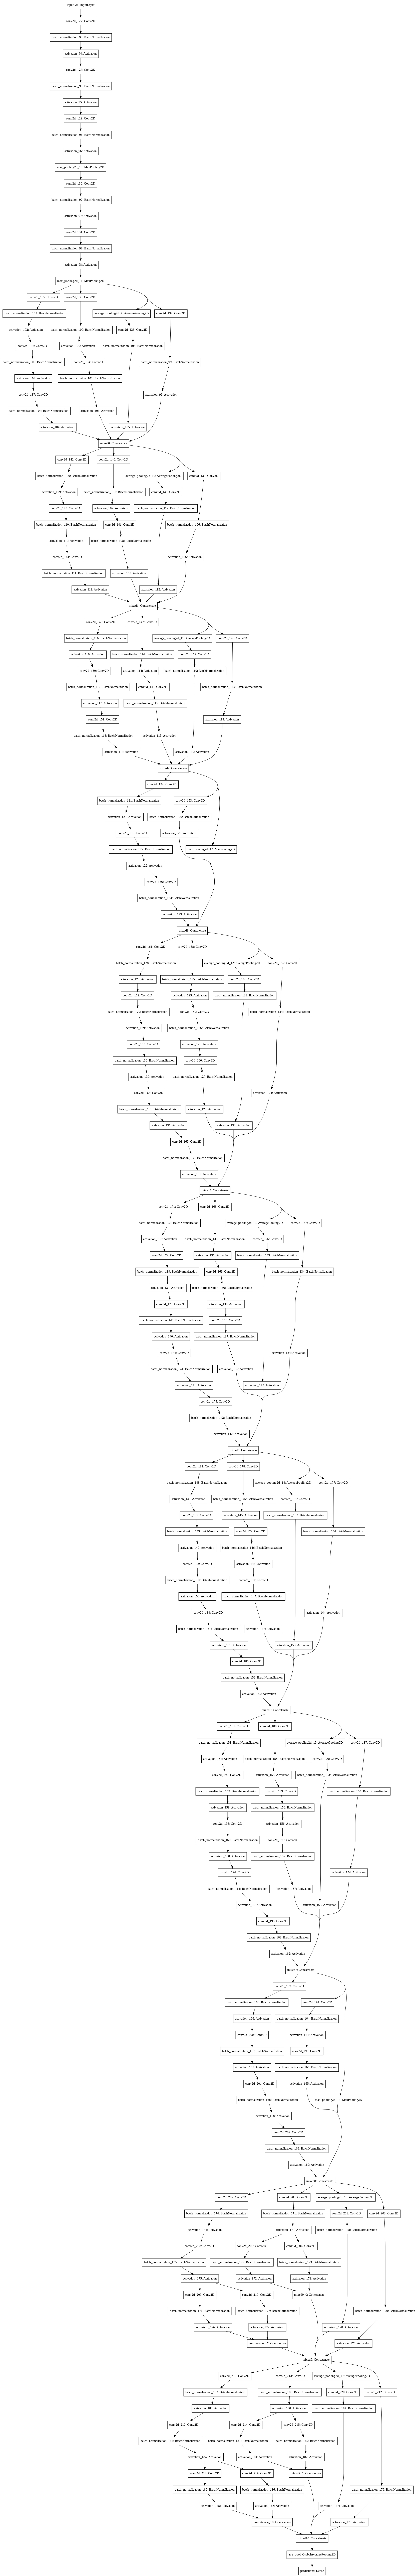

In [77]:
tf.keras.utils.plot_model(in3)

## Visual Geometry Group

> Very Deep Convolutional Networks for large-scale image recognition

```
Layer가 깊어지면 깊어질 수 록 성능이 좋아진다
```

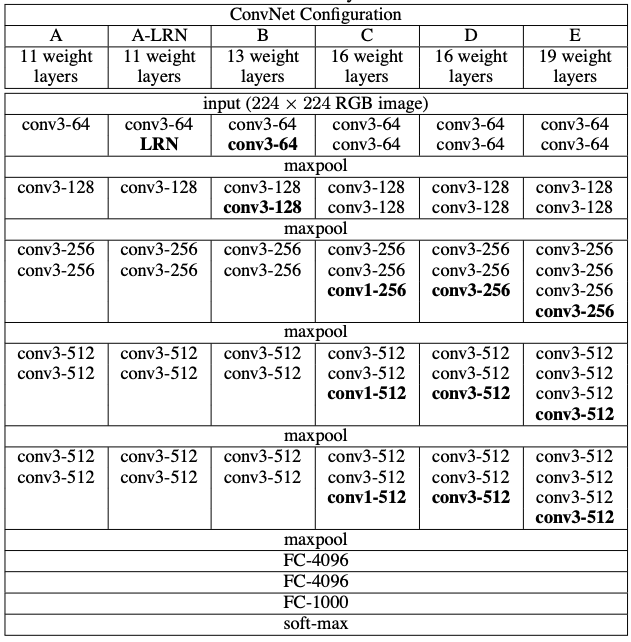

```
Abliation study 방식으로 모델 성능을 비교한다 

1. AlexNet vs AlexNet + LRN 
- LRN 기법은 성능 개선은 없고 메모리 사용량 및 연산 시간만 늘어났기에 사용을 하지 않는다

2. AlexNet vs AlexNet + conv layer 2개 추가 
- 성능 좋아짐 

3. AlexNet + conv layer 2개 vs AlexNet + conv layer 2개 + 1x1 convolution 3개   
- Nonlinearity만 추가 시켜 성능향상을 하는지 확인 => activation이 더 많아서 성능 더 좋아짐 (UAT)

4. AlexNet + conv layer 2개 + 1x1 convolution 3개 vs AlexNet + conv layer 5개 
- 성능 좋아짐 

5. AlexNet + conv layer 5개 vs AlexNet + conv layer 8개 
- 성능 좋아짐 

결국 Layer가 늘어나면 늘어날 수록 성능이 좋아졌다 
```

In [ ]:
import tensorflow as tf 

```
model을 불러와 사용하는 두 가지 방식

1. applications => Computer vision 분야에서 지원되는 모델을 지원한다 
2. tensorflow hub 
```

In [ ]:
vgg16 = tf.keras.applications.VGG16() # ImageNet 대회서 2등, 학습된 모델을 그대로 사용할 수 있다  

In [ ]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
vgg16.weights

In [ ]:
vgg16.__class__

keras.engine.functional.Functional

## 3x3을 쓰는 이유

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 6s 0us/step


In [ ]:
input_ = tf.keras.Input((32,32,3))
x = tf.keras.layers.Conv2D(2,5)(input_) # filter 2개 5x5 
model = tf.keras.models.Model(input_, x)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 2)         152       
Total params: 152
Trainable params: 152
Non-trainable params: 0
_________________________________________________________________


In [78]:
input_ = tf.keras.Input((32,32,3))
x = tf.keras.layers.Conv2D(2,3)(input_) 
x = tf.keras.layers.Conv2D(2,3)(x) 
model = tf.keras.models.Model(input_, x)

In [79]:
model.summary() # 3x3이 더 좋다 / 5x5일 때와 shape은 같지만 activation을 여러개 사용했고 파라미터 수가 줄어들었기 때문에 성능이 더 좋아졌다 

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_221 (Conv2D)          (None, 30, 30, 2)         56        
_________________________________________________________________
conv2d_222 (Conv2D)          (None, 28, 28, 2)         38        
Total params: 94
Trainable params: 94
Non-trainable params: 0
_________________________________________________________________


In [95]:
input_ = tf.keras.Input((32,32,3))
x = tf.keras.layers.Conv2D(2,3)(input_) 
x = tf.keras.layers.Conv2D(2,3)(x)
x = tf.keras.layers.Conv2D(2,3)(x) 
model = tf.keras.models.Model(input_, x)

In [96]:
model.summary() # 3x3으로 더 큰 receptive field를 대체 할 수 있다 

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_243 (Conv2D)          (None, 30, 30, 2)         56        
_________________________________________________________________
conv2d_244 (Conv2D)          (None, 28, 28, 2)         38        
_________________________________________________________________
conv2d_245 (Conv2D)          (None, 26, 26, 2)         38        
Total params: 132
Trainable params: 132
Non-trainable params: 0
_________________________________________________________________


```
보통 첫번째 layer는 5x5 또는 7x7 filter를 사용하고 (처음부터 3x3을 사용하면 메모리를 너무 많이차지 하기 때문에 오히려 성능 저하가 될 수 있다) 
그 다음 layer 부터는 3x3을 사용하면 성능이 좋다  
```



## Deep Residual Learning for Image Recognition

> ResNet은 인간을 뛰어넘은 첫번째 모델 <br>
> Residual => 실제값 - 예측값 (잔차) 

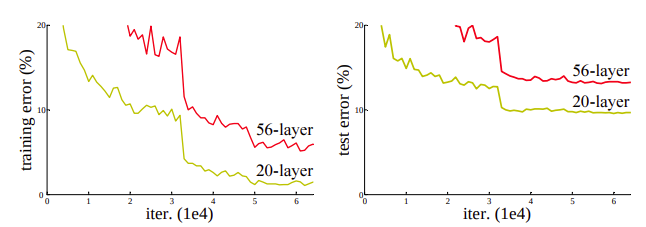

```
layer가 56개로 깊어지면서 gradient vanishing문제가 다시 떠오르기 시작했다 (relu로 해결되지 못하는 문제가 발생) 
underfitting
```

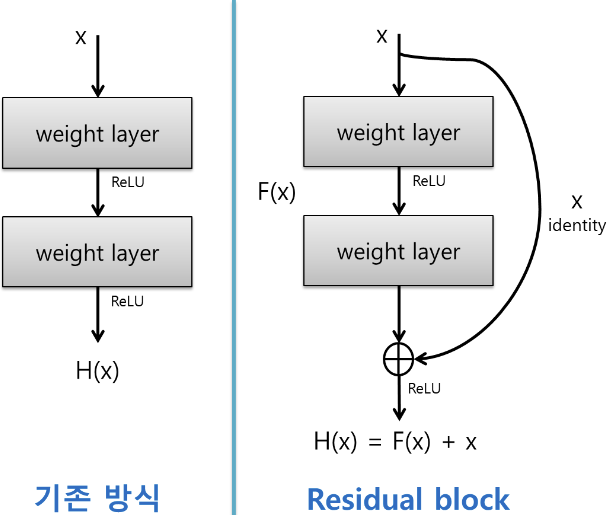

```
처음에 학습했던 것들을 점차 잊게되면서 목표로 부터 멀어지게 되는 현상이 생겼다 
그래서 해결책으로 Short cut 즉, residual block을 도입하게 되었다 

LSTM에서 아이디어를 얻어 자신의 값을 더함으로써 값을 유지시키고 목표를 잃지 않고 지속적으로 학습하게 된다   

기존의 신경망은 입력값 x를 타겟값 y로 매핑하는 함수 H(x)를 얻는 것이 목적이었다. 
그러나 ResNet은 F(x) + x를 최소화하는 것을 목적으로 한다. 
x는 현시점에서 변할 수 없는 값이므로 F(x)를 0에 가깝게 만드는 것이 목적이 된다. 
F(x)가 0이 되면 출력과 입력이 모두 x로 같아지게 된다. 
F(x) = H(x) - x이므로 F(x)를 최소로 해준다는 것은 H(x) - x를 최소로 해주는 것과 동일한 의미를 지닌다. 
여기서 H(x) - x를 잔차(residual)라고 한다. 
즉, 잔차를 최소로 해주는 것이므로 ResNet이란 이름이 붙게 된다. 

Batch Normalization 사용 => underfitting을 막아주면서 dropout을 사용하지 않고 좋은 성능을 얻게 되었다 
```

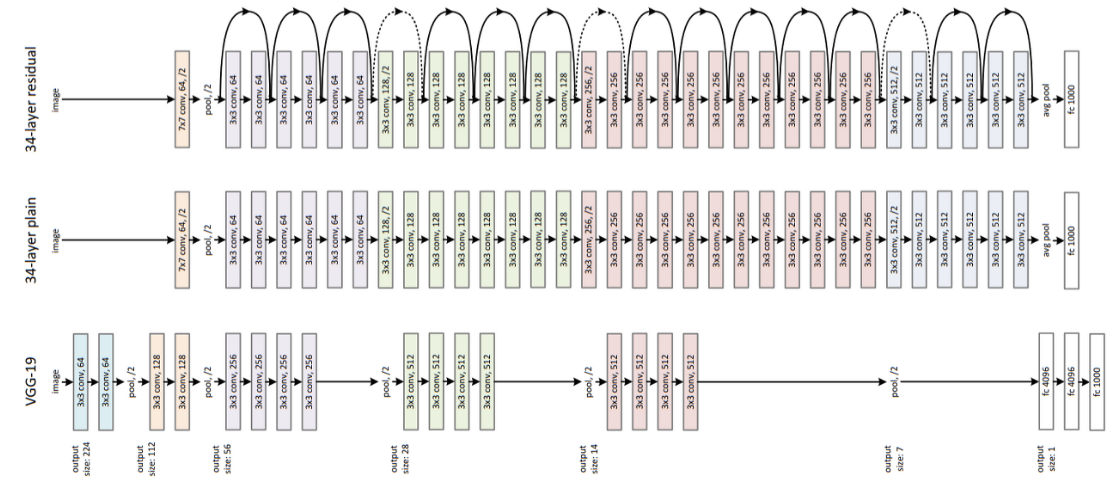

```
vgg19와 34-layer plain을 비교했을 때 34-layer는 가장 앞 layer에서  7x7 filter를 적용했고 레이어 수를 두 배 가까이 늘렸다 
그리고 맨마지막에 flatten을 쓰지 않고 average pooling을 사용했더니 34-layer가 성능이 더 좋았다 

더 나아가 34-layer에서 residual block을 추가한 결과 추가하지 않은 것보다 오차율이 감소한 것을 확인할 수 있었다 
```

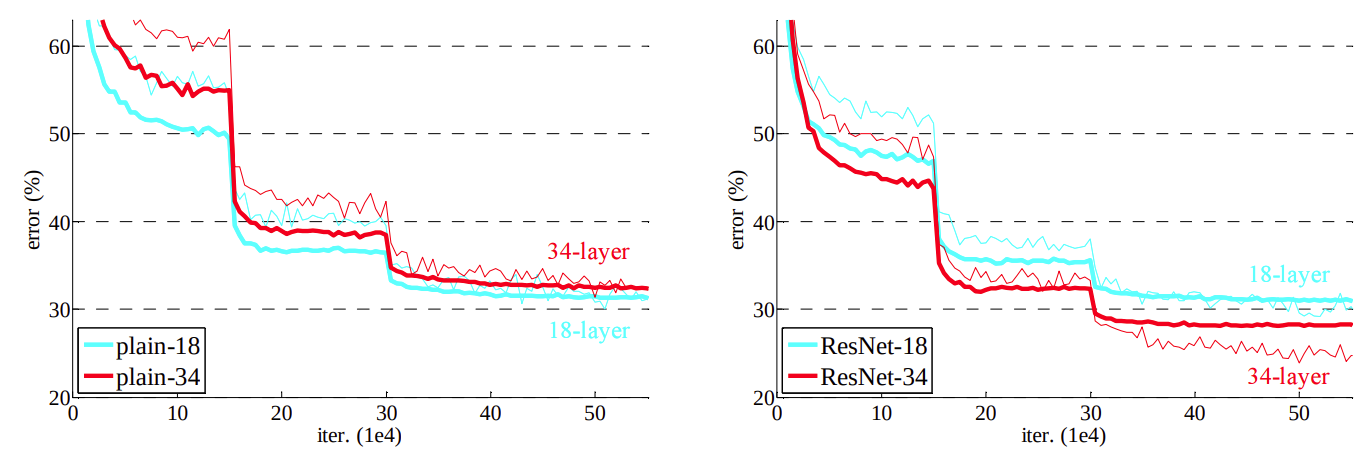

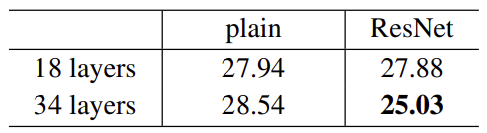

```
Residual block과 Batch Normalization의 조합으로 훨씬 더 깊은 layer가 가능해졌다 
결국 총 152 layer를 쌓을 수 있게 되었다  
```